In [1]:
import torch
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import numpy as np
import cv2
from PIL import Image
import os

In [2]:
# Load the dataset
dataset = torchvision.datasets.VOCDetection(
    root='./data',
    year='2012',
    image_set='train',
    download=True,
    transform=T.ToTensor()
)


100%|██████████| 1999639040/1999639040 [02:28<00:00, 13491486.50it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [3]:
# List of classes to keep
selected_classes = ["person", "chair", "car", "dog", "bottle"]

# Create a new list to store the filtered dataset
filtered_dataset = []

# Iterate through the original dataset
for image, target in dataset:
    keep_image = False
    for obj in target['annotation']['object']:
        if obj['name'] in selected_classes:
            keep_image = True
            break
    if keep_image:
        filtered_dataset.append((image, target))

# Print the length of the filtered dataset
print(f"Length of filtered dataset: {len(filtered_dataset)}")

Length of filtered dataset: 3442


In [3]:
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transforms):
        self.dataset = dataset
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(x[0] for x in self.dataset)
        self.targets = list(x[1] for x in self.dataset)
        self.objects = [x['annotation']['object'] for x in self.targets]
        self.annotations = [[x[i]['bndbox'] for i in range(len(x))] for x in self.objects]
        self.classes = [[x[i]['name'] for i in range(len(x))] for x in self.objects]
    
    
    def create_mask(self, img_shape, bbox):
        """Creates a binary mask for a given bounding box."""
        mask = np.zeros(img_shape, dtype=np.uint8)
        xmin, ymin, xmax, ymax = map(int, bbox)
        mask[ymin:ymax, xmin:xmax] = 1
        return mask


    def __getitem__(self, idx):
        # load images and masks
        img = self.imgs[idx]
        # first id is the background, so remove it
        num_objs = len(self.objects[idx])



        # get bounding box coordinates for each mask
        boxes_list =  boxes_list = [[int(box['xmin']), int(box['ymin']), int(box['xmax']), int(box['ymax'])] for box in self.annotations[idx]]
        boxes = torch.as_tensor(boxes_list, dtype=torch.float32) # Now convert the list of lists to a tensor

        # Create masks for each object
        img_shape = (img.shape[-2], img.shape[-1])  # Get the image dimensions
        masks = [self.create_mask(img_shape, bbox) for bbox in boxes_list]
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        class_to_idx = {'person': 0, 'chair': 1, 'car': 2, 'dog': 3, 'bottle': 4,'tvmonitor' :5, 'aeroplane':6, 'cat':7, 'sheep':8, 'motorbike':9, 
                        'sofa':10, 'pottedplant':11, 'horse':12, 'bicycle':13, 'cow':14, 'train':15, 'bus':16, 'boat':17, 'diningtable':18, 'bird':19}
        labels =self.classes[idx]
        labels = [class_to_idx[label] for label in labels]
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        target['masks'] = masks

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
from torchvision.transforms import v2 as T

def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [5]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2024-08-27 18:12:07--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: 'engine.py'

     0K ...                                                   100% 47.1M=0s

2024-08-27 18:12:08 (47.1 MB/s) - 'engine.py' saved [4063/4063]

--2024-08-27 18:12:08--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
Savin

0

In [6]:
# Create the dataset and dataloader
voc_dataset = PennFudanDataset(dataset, transforms=get_transform(train=True))

In [7]:
import utils
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    voc_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    voc_dataset, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [8]:
# Create the Mask R-CNN model with ResNet-50 backbone
backbone = resnet_fpn_backbone('resnet50', pretrained=True)
model = MaskRCNN(backbone, num_classes=21)  # num_classes=2 (background + object)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676

In [12]:
# import utils
# # split the dataset in train and test set
# indices = torch.randperm(len(dataset)).tolist()

# dataset_train = PennFudanDataset(filtered_dataset, get_transform(train=True))
# dataset_test = PennFudanDataset(filtered_dataset , get_transform(train=False))

In [12]:
# dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
# dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

In [13]:
# data_loader_test = torch.utils.data.DataLoader(
#     dataset_test,
#     batch_size=1,
#     shuffle=False,
#     collate_fn=utils.collate_fn
# )

In [14]:
for image, target in data_loader :
    print(target)
    break

({'boxes': tensor([[178.,  21., 500., 375.],
        [  1., 304., 280., 375.],
        [  1.,  20., 109., 314.],
        [  1., 246.,  90., 375.]]), 'labels': tensor([ 0, 18,  0,  4]), 'image_id': 1885, 'area': tensor([113988.,  19809.,  31752.,  11481.]), 'iscrowd': tensor([0, 0, 0, 0]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 1, 1,  ..., 0, 0, 0],
         [0, 1, 1,  ..., 0, 0, 0],
         [0, 1, 1,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ...

In [9]:
# Training loop setup (assuming training loop similar to FRCNN)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [10]:
# Define optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [11]:
pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 20.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
from engine import train_one_epoch, evaluate

num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

/tmp/ipykernel_37/719350840.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_37/719350840.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)
/tmp/ipykernel_37/719350840.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pyt

Epoch: [0]  [   0/2859]  eta: 2:55:54  lr: 0.000010  loss: 4.6226 (4.6226)  loss_classifier: 3.0647 (3.0647)  loss_box_reg: 0.0245 (0.0245)  loss_mask: 0.7810 (0.7810)  loss_objectness: 0.6988 (0.6988)  loss_rpn_box_reg: 0.0536 (0.0536)  time: 3.6917  data: 1.7372  max mem: 2156
Epoch: [0]  [  10/2859]  eta: 0:30:05  lr: 0.000060  loss: 4.7542 (4.7683)  loss_classifier: 3.0476 (3.0417)  loss_box_reg: 0.0146 (0.0123)  loss_mask: 0.9767 (0.9729)  loss_objectness: 0.6997 (0.6992)  loss_rpn_box_reg: 0.0294 (0.0422)  time: 0.6338  data: 0.1610  max mem: 3295
Epoch: [0]  [  20/2859]  eta: 0:23:02  lr: 0.000110  loss: 4.5909 (4.6667)  loss_classifier: 2.9549 (2.9383)  loss_box_reg: 0.0111 (0.0131)  loss_mask: 0.9474 (0.9670)  loss_objectness: 0.6976 (0.6978)  loss_rpn_box_reg: 0.0336 (0.0504)  time: 0.3269  data: 0.0055  max mem: 3296
Epoch: [0]  [  30/2859]  eta: 0:20:53  lr: 0.000160  loss: 4.2612 (4.4183)  loss_classifier: 2.5791 (2.7505)  loss_box_reg: 0.0108 (0.0138)  loss_mask: 0.8193 (

/tmp/ipykernel_37/719350840.py:43: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


creating index...
index created!
Test:  [   0/5717]  eta: 1:53:48  model_time: 0.2848 (0.2848)  evaluator_time: 0.0966 (0.0966)  time: 1.1944  data: 0.8078  max mem: 4335
Test:  [ 100/5717]  eta: 0:19:59  model_time: 0.1495 (0.1478)  evaluator_time: 0.0461 (0.0472)  time: 0.2077  data: 0.0124  max mem: 4335
Test:  [ 200/5717]  eta: 0:18:44  model_time: 0.1315 (0.1446)  evaluator_time: 0.0421 (0.0457)  time: 0.1945  data: 0.0033  max mem: 4335
Test:  [ 300/5717]  eta: 0:18:46  model_time: 0.1777 (0.1485)  evaluator_time: 0.0544 (0.0476)  time: 0.2281  data: 0.0040  max mem: 4335
Test:  [ 400/5717]  eta: 0:18:50  model_time: 0.1725 (0.1516)  evaluator_time: 0.0538 (0.0490)  time: 0.2136  data: 0.0038  max mem: 4335
Test:  [ 500/5717]  eta: 0:18:35  model_time: 0.1617 (0.1526)  evaluator_time: 0.0486 (0.0495)  time: 0.2051  data: 0.0042  max mem: 4335
Test:  [ 600/5717]  eta: 0:18:12  model_time: 0.1758 (0.1520)  evaluator_time: 0.0543 (0.0491)  time: 0.2168  data: 0.0038  max mem: 4335
T

In [13]:
len(data_loader_test)

5717

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.utils import draw_bounding_boxes

In [15]:
# Load a sample image
img, _ = dataset[0]  # Replace 0 with any index of your choice

In [16]:
# Unsqueeze to add a batch dimension
img = img.unsqueeze(0).to(device)

In [17]:
model.eval()
with torch.no_grad():
    prediction = model(img)

In [18]:
# Get the predicted masks, bounding boxes, and labels
pred_masks = prediction[0]['masks'].cpu()
pred_boxes = prediction[0]['boxes'].cpu()
pred_labels = prediction[0]['labels'].cpu()

In [19]:
# Apply a threshold to the masks to create binary masks
pred_masks = pred_masks > 0.5  # Threshold for the mask

In [20]:
# Convert the tensor image to a PIL image
img_cpu = img.squeeze(0).cpu()
img_pil = to_pil_image(img_cpu)

In [21]:
# Convert predicted masks to an RGB image for visualization
masks_img = np.zeros((img_cpu.shape[1], img_cpu.shape[2], 3), dtype=np.uint8)

In [22]:
for i in range(pred_masks.shape[0]):
    # Convert binary mask to a uint8 array
    mask = pred_masks[i].squeeze().numpy().astype(np.uint8)
    
    # Assign a random color to each mask
    color = np.random.randint(0, 255, (1, 3), dtype=np.uint8)
    
    # Apply the color to the mask
    masks_img[mask == 1] = color

In [23]:
# Overlay the masks on the original image
img_with_masks = np.array(img_pil) * 0.5 + masks_img * 0.5
img_with_masks = img_with_masks.astype(np.uint8)

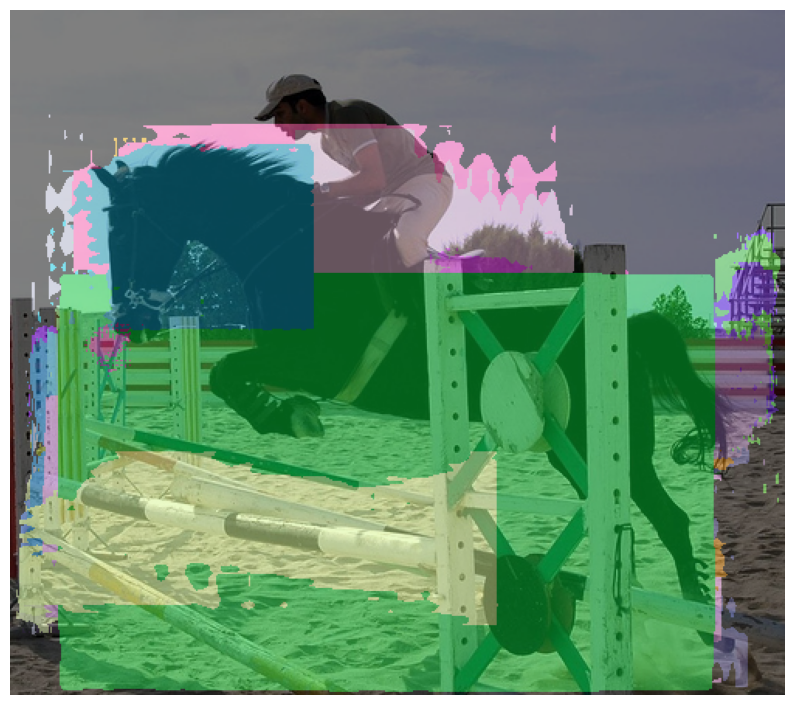

In [24]:
# Display the image with masks
plt.figure(figsize=(10, 10))
plt.imshow(img_with_masks)
plt.axis('off')
plt.show()

In [ ]:
# Save the model
torch.save(model.state_dict(), 'mask_rcnn_voc.pth')

print('Training complete and model saved!')